# ✨ Capstone Project: MitigasiKita - Analisis Data Gempa dan Tsunami ✨
---


## 🚀 Tim Proyek

**ID Tim:** CC25-CF278

**Anggota Tim:**
* 👨‍💻 **(ML)** MC172D5Y1422 - Dearmawan - Universitas Mikroskil - [Aktif]
* 👩‍💻 **(ML)** MC172D5X1418 - Julianti - Universitas Mikroskil - [Aktif]
* 👨‍💻 **(ML)** MC634D5Y1076 – Zainal Saputra - Universitas - [Aktif]
* 🛠️ **(FEBE)** FC614D5X1635 – Puput Purwaningsih - Universitas Nurdin Hamzah - [Aktif]
* 🛠️ **(FEBE)** FC299D5X2118 – Aprilia Nurhaliza - Universitas Pendidikan Indonesia - [Aktif]
* 🛠️ **(FEBE)** FC613D5Y1033 – Andres Junika Putra – Universitas Mercu Buana Yogyakarta - [Aktif]

---

## 🎯 Pendahuluan Proyek

Proyek **MitigasiKita** bertujuan mengembangkan sistem peringatan dini dan panduan evakuasi gempa serta tsunami menggunakan teknologi **Machine Learning**. Analisis data gempa dan cuaca dilakukan untuk memahami pola bencana dan mendukung model prediksi risiko (Aman, Waspada, Berbahaya).

### 📊 Dataset Utama
* ☀️ `cuaca_indonesia`: Data cuaca di Indonesia.
* 🌍 `katalog_gempa_gabungan_urut`: Katalog gabungan data gempa yang diurutkan.
* 📂 Dataset gabungan: `gempa_dan_cuaca_dengan_prediksi_v2.csv`.

---

## ⚙️ Persiapan Lingkungan dan Import Library

Mengimport semua library yang dibutuhkan dan setup konfigurasi dasar seperti palet warna untuk visualisasi.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from geopy.geocoders import Nominatim
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import joblib
import os
import warnings
import requests
from datetime import datetime

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 📊 Memuat Dataset

Memuat dataset gabungan yang sudah disiapkan (`gempa_dan_cuaca_dengan_prediksi_v2.csv`).

In [2]:
# Memuat dataset
df = pd.read_csv('gempa_dan_cuaca_dengan_prediksi_v2.csv')

# Menampilkan informasi dasar
print(f"Jumlah baris: {df.shape[0]}")
print(f"Jumlah kolom: {df.shape[1]}")
print("\nInfo dataset:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())

# Menghapus baris dengan missing values
df = df.dropna()
print(f"\nJumlah baris setelah pembersihan: {df.shape[0]}")
print(f"Jumlah kolom setelah pembersihan: {df.shape[1]}")

# Menampilkan distribusi kelas target
print("\nDistribusi kelas target:")
print(df['prediksi_risiko'].value_counts())

# Menampilkan 5 baris pertama
df.head()

Jumlah baris: 54901
Jumlah kolom: 22

Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54901 entries, 0 to 54900
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   eventID             54901 non-null  object 
 1   datetime            54901 non-null  object 
 2   latitude            54901 non-null  float64
 3   longitude           54901 non-null  float64
 4   magnitude           54838 non-null  float64
 5   mag_type            54838 non-null  object 
 6   depth               54901 non-null  int64  
 7   phasecount          54899 non-null  float64
 8   azimuth_gap         54901 non-null  float64
 9   location            54901 non-null  object 
 10  agency              54901 non-null  object 
 11  date                54901 non-null  object 
 12  city                54901 non-null  object 
 13  time                54901 non-null  object 
 14  temperature_2m_max  54901 non-null  float64
 15  t

,eventID,datetime,latitude,longitude,magnitude,mag_type,depth,phasecount,azimuth_gap,location,...,city,time,temperature_2m_max,temperature_2m_min,precipitation_sum,weathercode,windspeed_10m_max,potensi_gempa,potensi_tsunami,prediksi_risiko
0,bmg2020aaac,2020-01-01 00:02:21.183174+00:00,-2.730515,127.898819,3.294128,M,17,16.0,74.870178,Ceram Sea,...,Ambon,2020-01-01,32.3,25.6,4.6,63,12.8,Rendah,Rendah,Aman
1,bmg2020aaiv,2020-01-01 04:27:36.113891+00:00,-3.387574,128.378189,2.251033,M,10,7.0,161.783195,"Seram, Indonesia",...,Ambon,2020-01-01,32.3,25.6,4.6,63,12.8,Rendah,Rendah,Aman
2,bmg2020aaje,2020-01-01 04:38:04.738063+00:00,2.061754,126.647492,4.114948,M,10,11.0,95.528030,Northern Molucca Sea,...,Ternate,2020-01-01,30.6,26.3,2.6,53,13.8,Rendah,Rendah,Aman
3,bmg2020aaky,2020-01-01 05:31:55.150735+00:00,-9.256731,121.274017,3.817840,M,97,25.0,61.711212,Savu Sea,...,Kupang,2020-01-01,30.1,25.3,11.2,63,10.8,Rendah,Rendah,Waspada
4,bmg2020aalx,2020-01-01 06:01:13.844505+00:00,-6.750792,129.847611,4.815453,M,173,42.0,57.522709,Banda Sea,...,Ambon,2020-01-01,32.3,25.6,4.6,63,12.8,Rendah,Rendah,Aman


## 📈 Exploratory Data Analysis (EDA)

Melakukan analisis awal untuk memahami struktur, statistik, dan distribusi data.

--- Pemeriksaan Missing Values per Kolom ---
eventID               0
datetime              0
latitude              0
longitude             0
magnitude             0
mag_type              0
depth                 0
phasecount            0
azimuth_gap           0
location              0
agency                0
date                  0
city                  0
time                  0
temperature_2m_max    0
temperature_2m_min    0
precipitation_sum     0
weathercode           0
windspeed_10m_max     0
potensi_gempa         0
potensi_tsunami       0
prediksi_risiko       0
dtype: int64

--- Informasi Dataset ---
<class 'pandas.core.frame.DataFrame'>
Index: 54836 entries, 0 to 54900
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   eventID             54836 non-null  object 
 1   datetime            54836 non-null  object 
 2   latitude            54836 non-null  float64
 3   longitude           54836 non-nul

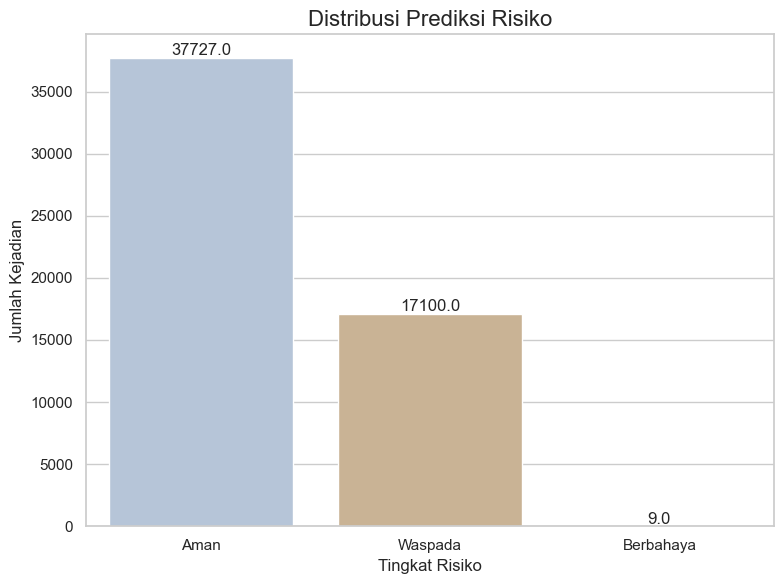


--- Visualisasi: Distribusi Magnitude Gempa ---


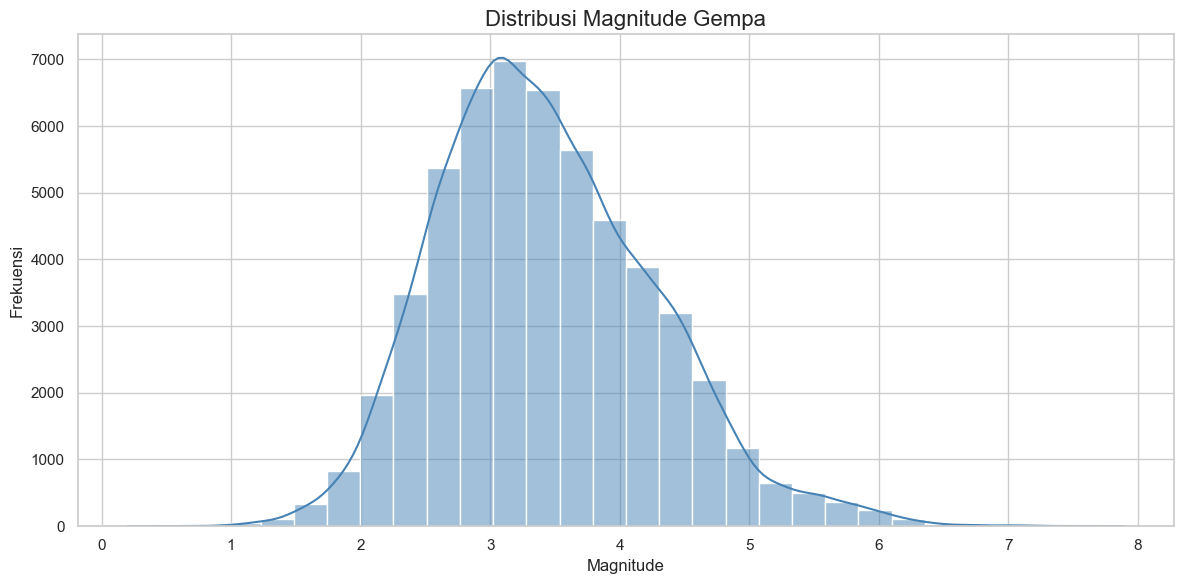


--- Visualisasi: Distribusi Kedalaman Gempa ---


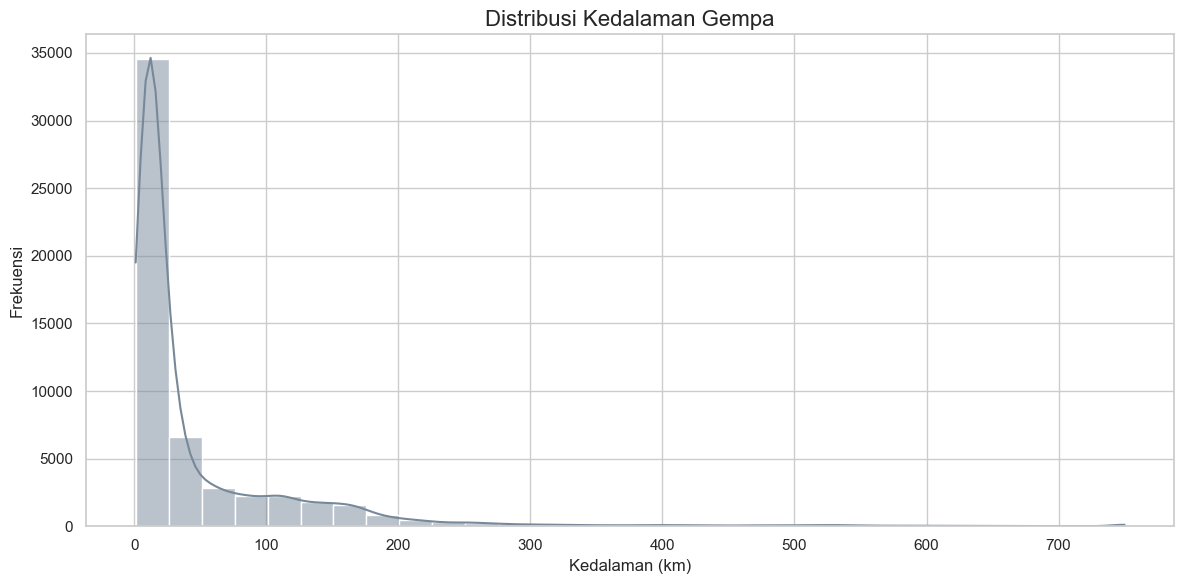


--- Visualisasi: Distribusi Jumlah Presipitasi Harian ---


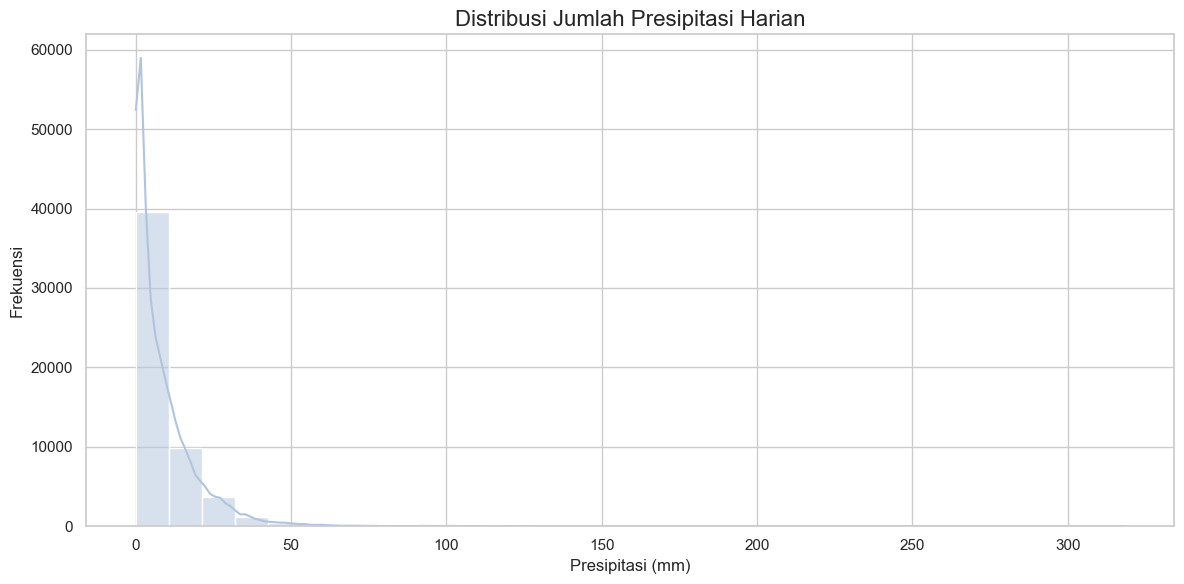


--- Visualisasi: Distribusi Kecepatan Angin Maksimum Harian ---


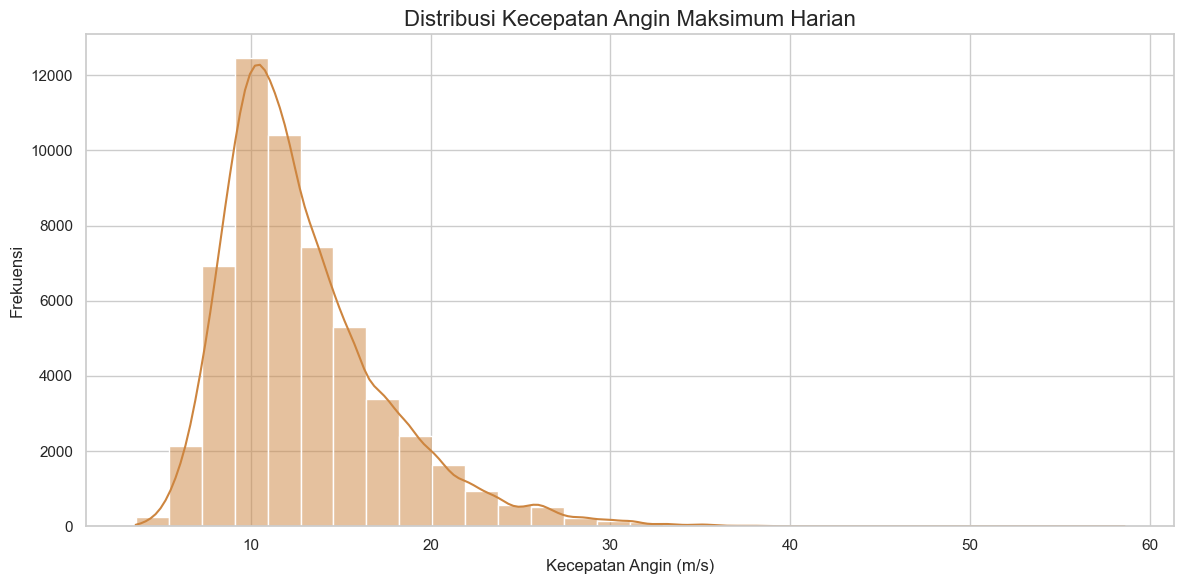


--- Visualisasi: Hubungan antara Magnitude dan Kedalaman Gempa ---


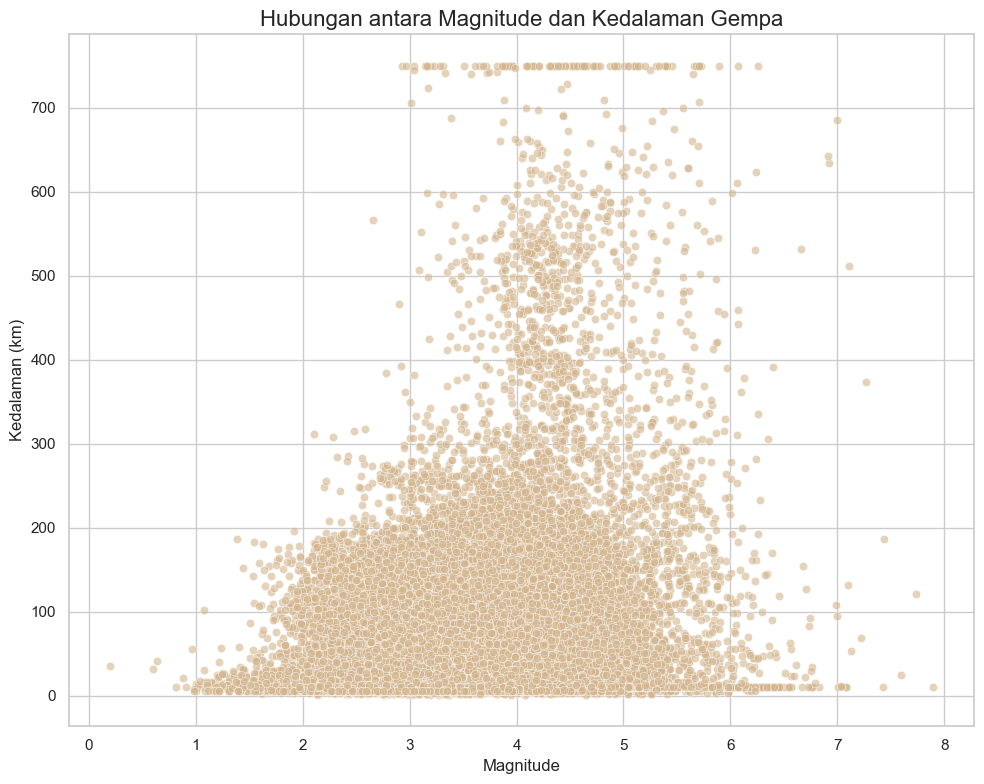


--- Visualisasi: Distribusi Cuaca Numerik per Kota ---


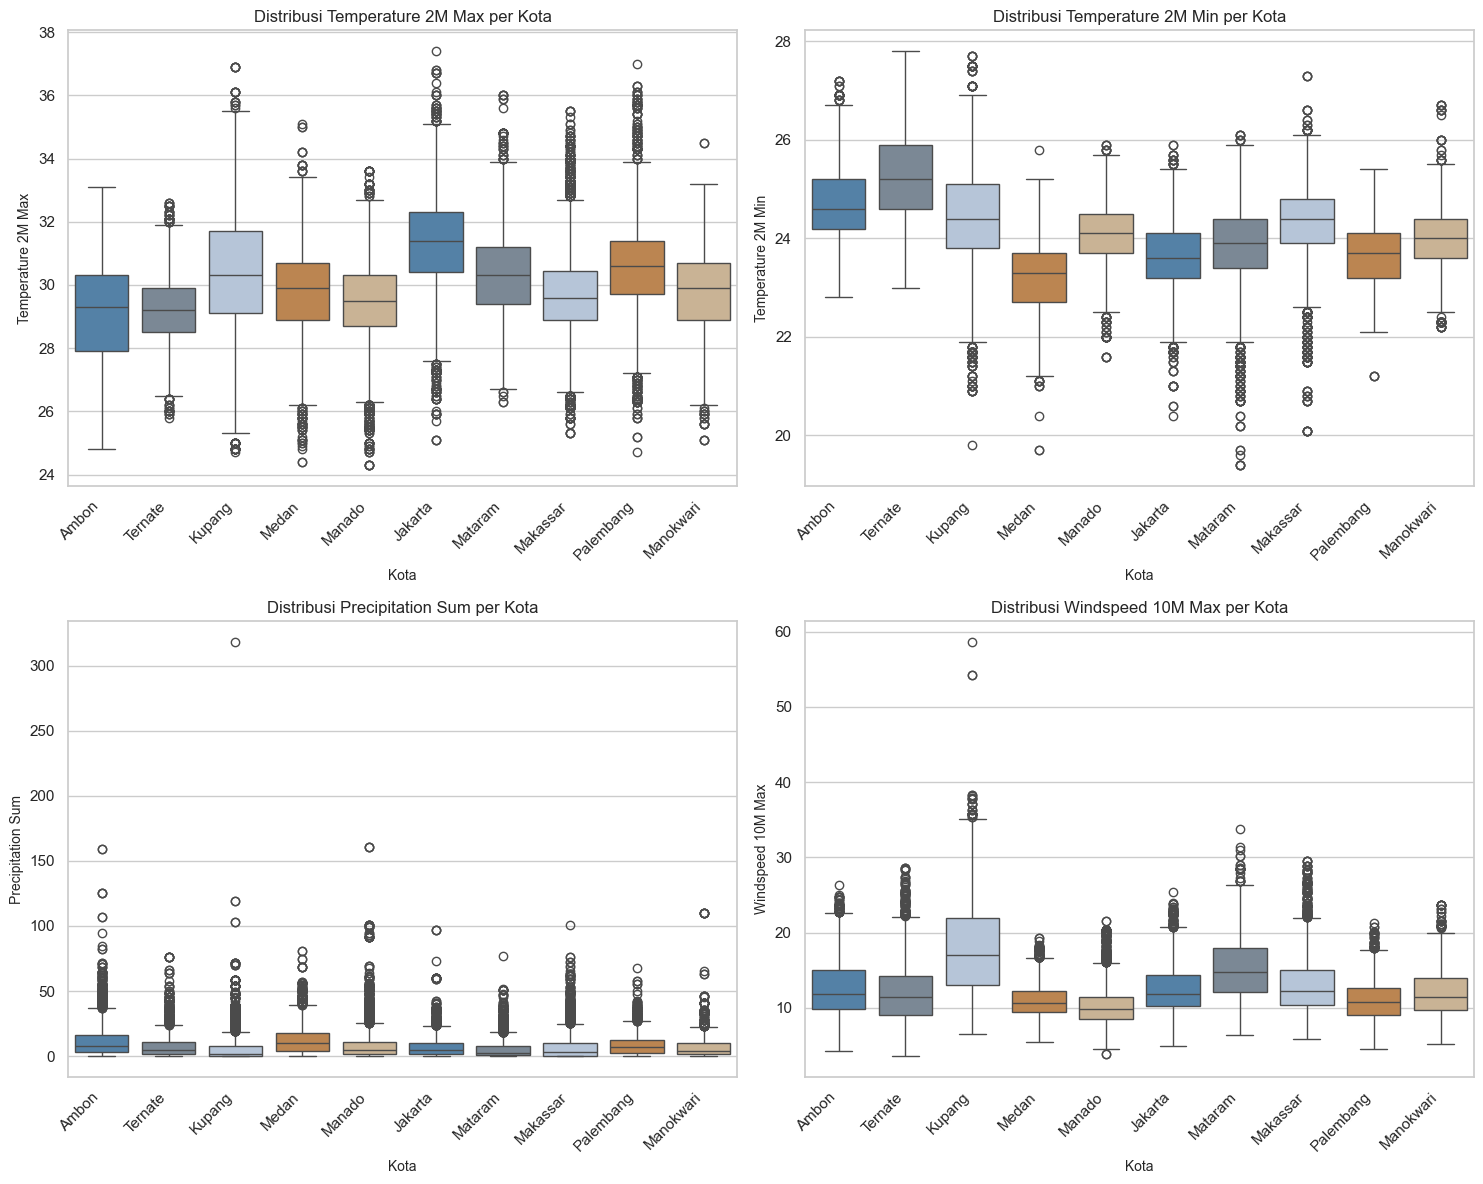


--- Visualisasi: Jumlah Kejadian per Bulan ---


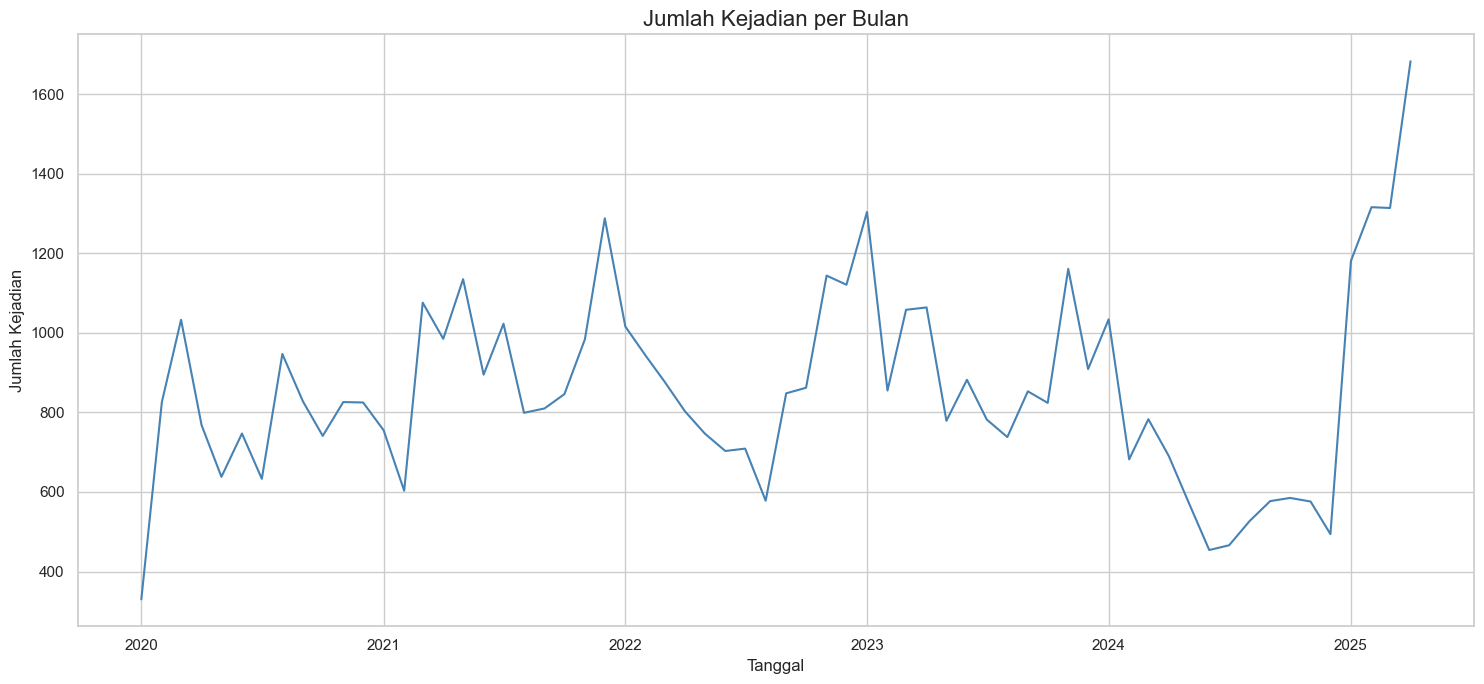


--- Visualisasi: Heatmap Korelasi Variabel Numerik ---


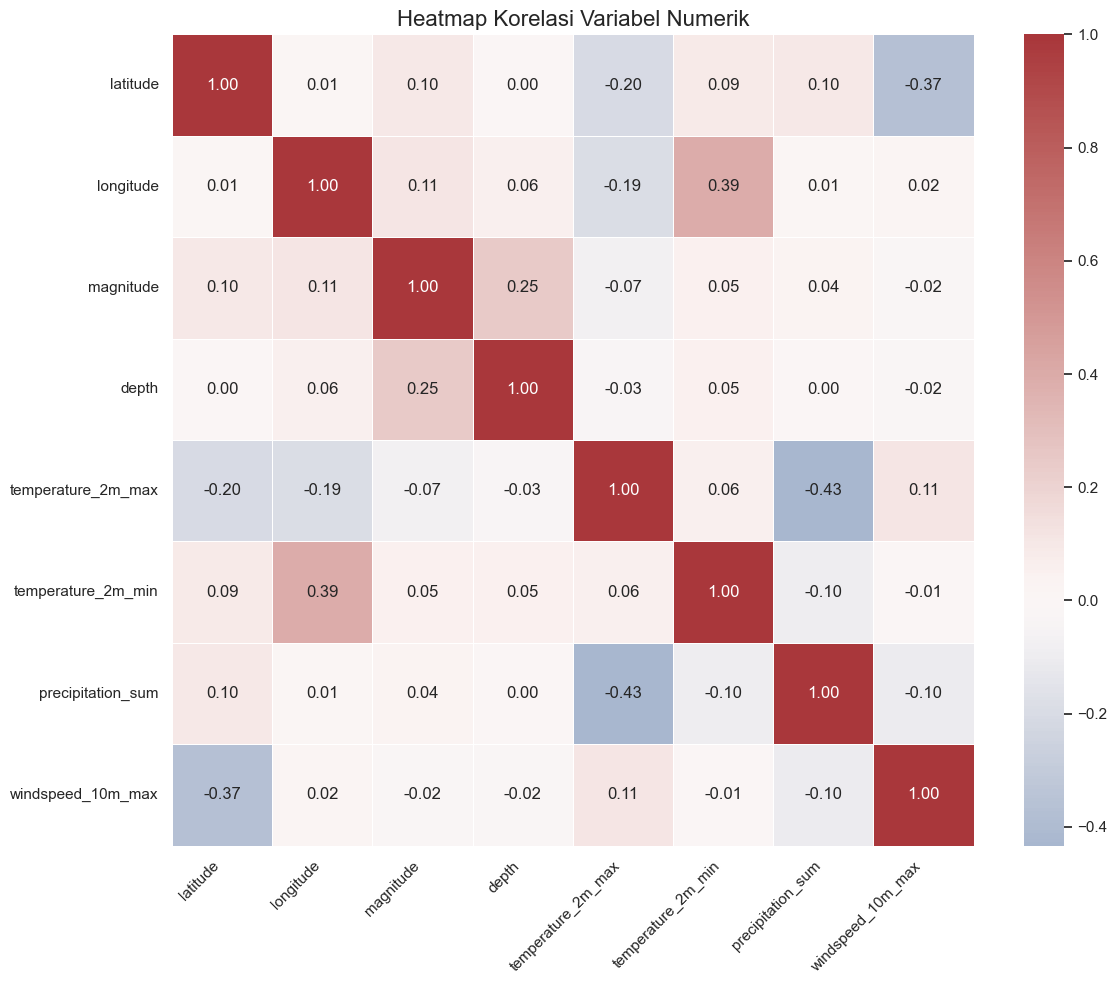

In [3]:
sns.set_theme(style="whitegrid")
custom_blue_brown_palette = ['#4682B4', '#778899', '#B0C4DE', '#CD853F', '#D2B48C']
sns.set_palette(custom_blue_brown_palette)

if df is not None:
    print("--- Pemeriksaan Missing Values per Kolom ---")
    print(df.isnull().sum())

    print("\n--- Informasi Dataset ---")
    df.info()

    print("\n--- Statistik Deskriptif ---")
    print(df.describe())

    print("\n--- Jumlah Data per Kategori Prediksi Risiko ---")
    if 'prediksi_risiko' in df.columns:
        print(df['prediksi_risiko'].value_counts())
    else:
        print("Kolom 'prediksi_risiko' tidak ditemukan.")

    print("\n--- Memulai Visualisasi Data ---")
else:
    print("Dataset belum dimuat, EDA tidak dapat dilakukan.")


if df is not None:

    # Visualisasi 1: Distribusi Prediksi Risiko (Countplot)
    print("\n--- Visualisasi: Distribusi Prediksi Risiko ---")
    if 'prediksi_risiko' in df.columns:
        df_valid_risk = df[df['prediksi_risiko'].isin(['Aman', 'Waspada', 'Berbahaya'])].copy()
        if not df_valid_risk.empty:
            plt.figure(figsize=(8, 6))
            risk_order = ['Aman', 'Waspada', 'Berbahaya']
            risk_colors_for_plot = [custom_blue_brown_palette[2], custom_blue_brown_palette[4], custom_blue_brown_palette[3]]
            ax = sns.countplot(data=df_valid_risk, x='prediksi_risiko', order=risk_order, palette=risk_colors_for_plot)
            plt.title('Distribusi Prediksi Risiko', fontsize=16)
            plt.xlabel('Tingkat Risiko', fontsize=12)
            plt.ylabel('Jumlah Kejadian', fontsize=12)
            for p in ax.patches:
                ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', xytext=(0, 5), textcoords='offset points')
            plt.tight_layout()
            plt.show()
        else:
            print("Tidak ada prediksi risiko valid ('Aman', 'Waspada', 'Berbahaya') untuk diplot.")
    else:
        print("Kolom 'prediksi_risiko' tidak ditemukan untuk plot distribusi.")

    # Visualisasi 2: Distribusi Magnitude (Histplot)
    print("\n--- Visualisasi: Distribusi Magnitude Gempa ---")
    if 'magnitude' in df.columns:
        if not df['magnitude'].dropna().empty:
            plt.figure(figsize=(12, 6))
            sns.histplot(data=df, x='magnitude', kde=True, bins=30, color=custom_blue_brown_palette[0])
            plt.title('Distribusi Magnitude Gempa', fontsize=16)
            plt.xlabel('Magnitude', fontsize=12)
            plt.ylabel('Frekuensi', fontsize=12)
            plt.tight_layout()
            plt.show()
        else:
            print("Tidak ada data magnitude (setelah dropna) yang valid untuk plot distribusi.")
    else:
        print("Kolom 'magnitude' tidak ditemukan untuk plot distribusi.")

    # Visualisasi 3: Distribusi Kedalaman (Histplot)
    print("\n--- Visualisasi: Distribusi Kedalaman Gempa ---")
    if 'depth' in df.columns:
        if not df['depth'].dropna().empty:
            plt.figure(figsize=(12, 6))
            sns.histplot(data=df, x='depth', kde=True, bins=30, color=custom_blue_brown_palette[1])
            plt.title('Distribusi Kedalaman Gempa', fontsize=16)
            plt.xlabel('Kedalaman (km)', fontsize=12)
            plt.ylabel('Frekuensi', fontsize=12)
            plt.tight_layout()
            plt.show()
        else:
            print("Tidak ada data kedalaman (setelah dropna) yang valid untuk plot distribusi.")
    else:
        print("Kolom 'depth' tidak ditemukan untuk plot distribusi.")

    # Visualisasi 4: Distribusi Presipitasi (Histplot)
    print("\n--- Visualisasi: Distribusi Jumlah Presipitasi Harian ---")
    if 'precipitation_sum' in df.columns:
        if not df['precipitation_sum'].dropna().empty:
            plt.figure(figsize=(12, 6))
            sns.histplot(data=df, x='precipitation_sum', kde=True, bins=30, color=custom_blue_brown_palette[2])
            plt.title('Distribusi Jumlah Presipitasi Harian', fontsize=16)
            plt.xlabel('Presipitasi (mm)', fontsize=12)
            plt.ylabel('Frekuensi', fontsize=12)
            plt.tight_layout()
            plt.show()
        else:
            print("Tidak ada data presipitasi (setelah dropna) yang valid untuk plot distribusi.")
    else:
        print("Kolom 'precipitation_sum' tidak ditemukan untuk plot distribusi.")

    # Visualisasi 5: Distribusi Kecepatan Angin (Histplot)
    print("\n--- Visualisasi: Distribusi Kecepatan Angin Maksimum Harian ---")
    if 'windspeed_10m_max' in df.columns:
        if not df['windspeed_10m_max'].dropna().empty:
            plt.figure(figsize=(12, 6))
            sns.histplot(data=df, x='windspeed_10m_max', kde=True, bins=30, color=custom_blue_brown_palette[3])
            plt.title('Distribusi Kecepatan Angin Maksimum Harian', fontsize=16)
            plt.xlabel('Kecepatan Angin (m/s)', fontsize=12)
            plt.ylabel('Frekuensi', fontsize=12)
            plt.tight_layout()
            plt.show()
        else:
            print("Tidak ada data kecepatan angin (setelah dropna) yang valid untuk plot distribusi.")
    else:
        print("Kolom 'windspeed_10m_max' tidak ditemukan untuk plot distribusi.")

    # Visualisasi 6: Scatter Plot Magnitude vs Kedalaman
    print("\n--- Visualisasi: Hubungan antara Magnitude dan Kedalaman Gempa ---")
    if 'magnitude' in df.columns and 'depth' in df.columns:
        df_scatter = df.dropna(subset=['magnitude', 'depth'])
        if not df_scatter.empty:
            plt.figure(figsize=(10, 8))
            sns.scatterplot(data=df_scatter, x='magnitude', y='depth', alpha=0.6, color=custom_blue_brown_palette[4])
            plt.title('Hubungan antara Magnitude dan Kedalaman Gempa', fontsize=16)
            plt.xlabel('Magnitude', fontsize=12)
            plt.ylabel('Kedalaman (km)', fontsize=12)
            plt.tight_layout()
            plt.show()
        else:
            print("Tidak ada data magnitude dan kedalaman (setelah dropna) yang valid untuk scatter plot.")
    else:
        print("Kolom 'magnitude' atau 'depth' tidak ditemukan.")

    # Visualisasi 7: Boxplot Distribusi Cuaca Numerik per Kota
    print("\n--- Visualisasi: Distribusi Cuaca Numerik per Kota ---")
    numerical_cols_weather = ['temperature_2m_max', 'temperature_2m_min', 'precipitation_sum', 'windspeed_10m_max']
    if df is not None and all(col in df.columns for col in numerical_cols_weather) and 'city' in df.columns:
        df_weather_boxplot = df[numerical_cols_weather + ['city']].dropna()
        if not df_weather_boxplot.empty:
            top_cities = df_weather_boxplot['city'].value_counts().nlargest(10).index.tolist()
            df_weather_boxplot_filtered = df_weather_boxplot[df_weather_boxplot['city'].isin(top_cities)]

            if not df_weather_boxplot_filtered.empty:
                n_cols = 2
                n_rows = (len(numerical_cols_weather) + n_cols - 1) // n_cols
                plt.figure(figsize=(15, n_rows * 6))

                for i, col in enumerate(numerical_cols_weather):
                    plt.subplot(n_rows, n_cols, i + 1)
                    sns.boxplot(data=df_weather_boxplot_filtered, x='city', y=col, palette=custom_blue_brown_palette)
                    plt.title(f'Distribusi {col.replace("_", " ").title()} per Kota', fontsize=12)
                    plt.xlabel('Kota', fontsize=10)
                    plt.ylabel(col.replace("_", " ").title(), fontsize=10)
                    plt.xticks(rotation=45, ha='right')

                plt.tight_layout()
                plt.show()
            else:
                 print("Tidak ada data cuaca numerik atau kota yang cukup setelah filtering kota teratas.")
        else:
            print("Tidak ada data cuaca numerik atau kota (setelah dropna) yang valid untuk boxplot per kota.")
    else:
        print("Dataset belum dimuat atau kolom cuaca numerik atau 'city' tidak ditemukan.")


    # Visualisasi 8: Frekuensi Kejadian per Bulan (Line Plot)
    print("\n--- Visualisasi: Jumlah Kejadian per Bulan ---")
    if 'datetime' in df.columns:
        df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce', utc=True)
        df_events = df.dropna(subset=['datetime']).copy()
        df_events['year_month'] = df_events['datetime'].dt.to_period('M')
        event_counts_monthly = df_events.groupby('year_month').size()
        event_counts_monthly.index = event_counts_monthly.index.to_timestamp()

        if not event_counts_monthly.empty:
            plt.figure(figsize=(15, 7))
            sns.lineplot(data=event_counts_monthly, color=custom_blue_brown_palette[0])
            plt.title('Jumlah Kejadian per Bulan', fontsize=16)
            plt.xlabel('Tanggal', fontsize=12)
            plt.ylabel('Jumlah Kejadian', fontsize=12)
            plt.tight_layout()
            plt.show()
        else:
            print("Data tidak mencukupi untuk plot frekuensi event per bulan.")
    else:
        print("Kolom 'datetime' tidak ditemukan.")


    # Visualisasi 9: Heatmap Korelasi Variabel Numerik
    print("\n--- Visualisasi: Heatmap Korelasi Variabel Numerik ---")
    numerical_cols_combined = df.select_dtypes(include=np.number).columns.tolist()
    exclude_cols = ['weathercode', 'phasecount', 'azimuth_gap']
    numerical_cols_for_corr = [col for col in numerical_cols_combined if col not in exclude_cols and df[col].dropna().count() > 1]

    if numerical_cols_for_corr and len(numerical_cols_for_corr) > 1:
        plt.figure(figsize=(12, 10))
        correlation_matrix_combined = df[numerical_cols_for_corr].corr()
        sns.heatmap(correlation_matrix_combined, annot=True, cmap='vlag', fmt=".2f", linewidths=.5, center=0)
        plt.title('Heatmap Korelasi Variabel Numerik', fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print("Tidak ada kolom numerik yang relevan (setelah filter) atau kurang dari 2 untuk heatmap korelasi.")

else:
    print("Dataset belum dimuat, visualisasi tidak dapat dilakukan.")

## 🛠️ Preprocessing Data

Menyiapkan data untuk model Machine Learning: membersihkan, mengubah format, menangani nilai yang hilang, scaling, encoding, dan membagi data menjadi set training dan testing.

In [4]:
# Definisikan fitur numerik dan kategorikal (sesuai dengan app.py)
numeric_features = ['latitude', 'longitude', 'magnitude', 'depth', 'phasecount', 'azimuth_gap',
                    'temperature_2m_max', 'temperature_2m_min', 'precipitation_sum', 'windspeed_10m_max']
categorical_features = ['mag_type', 'location', 'agency', 'city', 'potensi_gempa', 'potensi_tsunami']
target = 'prediksi_risiko'

# Pisahkan fitur dan target
X = df[numeric_features + categorical_features]
y = df[target]

# Encode label target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

# Fit dan transform data
X_preprocessed = preprocessor.fit_transform(X)

# Simpan nama fitur untuk inferensi
preprocessor.feature_names_in_ = X.columns

# Tangani ketidakseimbangan kelas dengan SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_preprocessed, y_encoded)

# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Konversi target ke format kategorikal untuk pelatihan
y_train_categorical = to_categorical(y_train, num_classes=len(label_encoder.classes_))
y_test_categorical = to_categorical(y_test, num_classes=len(label_encoder.classes_))

print(f"Shape X_train: {X_train.shape}")
print(f"Shape X_test: {X_test.shape}")
print(f"Shape y_train: {y_train.shape}")
print(f"Shape y_test: {y_test.shape}")

Shape X_train: (90544, 97)
Shape X_test: (22637, 97)
Shape y_train: (90544,)
Shape y_test: (22637,)


## 🧠 Model Machine Learning: Pelatihan DNN

Membangun, mengkompilasi, dan melatih model Deep Neural Network (DNN) menggunakan data training yang sudah dipreproses dan di-oversample.

Epoch 1/10
2830/2830 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9301 - loss: 0.1753 - val_accuracy: 0.9941 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 2/10
2830/2830 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9875 - loss: 0.0335 - val_accuracy: 0.9932 - val_loss: 0.0139 - learning_rate: 0.0010
Epoch 3/10
2830/2830 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9905 - loss: 0.0250 - val_accuracy: 0.9944 - val_loss: 0.0134 - learning_rate: 0.0010
Epoch 4/10
2830/2830 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9929 - loss: 0.0197 - val_accuracy: 0.9967 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 5/10
2830/2830 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9936 - loss: 0.0171 - val_accuracy: 0.9976 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 6/10
2830/2830 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9950 - loss: 0.0142 - val_accuracy: 0.9975 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 7/10
2830/2830 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9

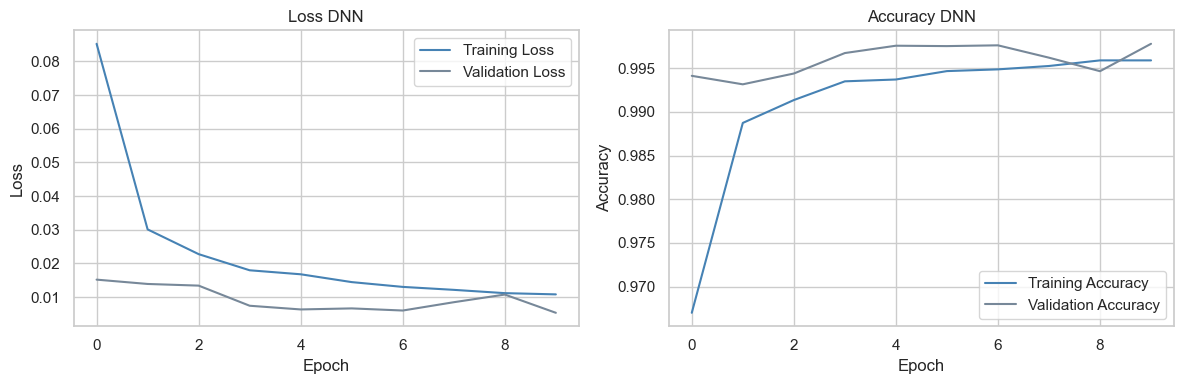

In [5]:
# Bangun model DNN
model_dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Kompilasi model
model_dnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callback untuk early stopping dan learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Latih model
history_dnn = model_dnn.fit(
    X_train, y_train_categorical,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test_categorical),
    callbacks=[early_stopping, lr_reducer],
    verbose=1
)

# Visualisasi hasil pelatihan
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_dnn.history['loss'], label='Training Loss')
plt.plot(history_dnn.history['val_loss'], label='Validation Loss')
plt.title('Loss DNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot akurasi
plt.subplot(1, 2, 2)
plt.plot(history_dnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy DNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 🧠 Model Machine Learning: Pelatihan CNN

Mencoba arsitektur Convolutional Neural Network (CNN) untuk data spasial.

Epoch 1/10
2830/2830 ━━━━━━━━━━━━━━━━━━━━ 55s 18ms/step - accuracy: 0.9518 - loss: 0.1235 - val_accuracy: 0.9930 - val_loss: 0.0155 - learning_rate: 0.0010
Epoch 2/10
2830/2830 ━━━━━━━━━━━━━━━━━━━━ 88s 31ms/step - accuracy: 0.9905 - loss: 0.0246 - val_accuracy: 0.9963 - val_loss: 0.0088 - learning_rate: 0.0010
Epoch 3/10
2830/2830 ━━━━━━━━━━━━━━━━━━━━ 62s 22ms/step - accuracy: 0.9938 - loss: 0.0174 - val_accuracy: 0.9960 - val_loss: 0.0093 - learning_rate: 0.0010
Epoch 4/10
2830/2830 ━━━━━━━━━━━━━━━━━━━━ 60s 21ms/step - accuracy: 0.9951 - loss: 0.0135 - val_accuracy: 0.9980 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 5/10
2830/2830 ━━━━━━━━━━━━━━━━━━━━ 61s 21ms/step - accuracy: 0.9962 - loss: 0.0108 - val_accuracy: 0.9973 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 6/10
2830/2830 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - accuracy: 0.9966 - loss: 0.0104 - val_accuracy: 0.9981 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 7/10
2830/2830 ━━━━━━━━━━━━━━━━━━━━ 52s 18ms/step - accura

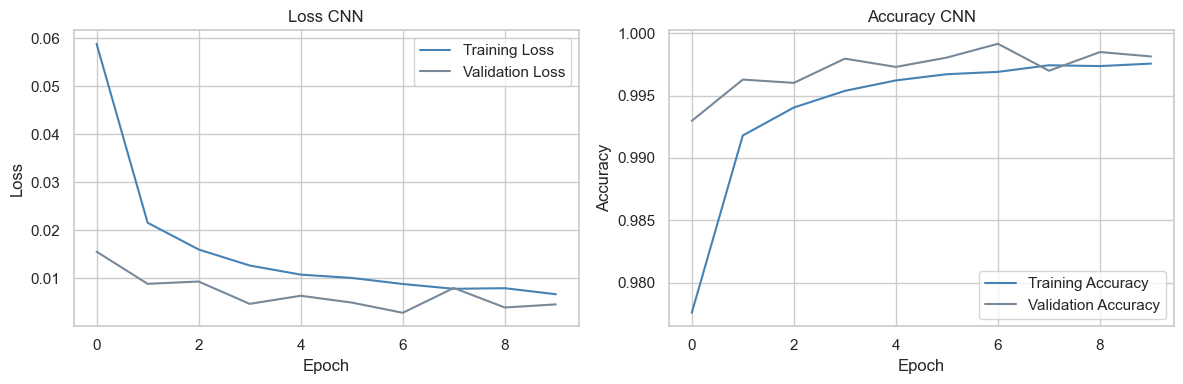

In [6]:
# Reshape data untuk CNN (tambahkan dimensi channel)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Bangun model CNN
model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.3),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Kompilasi model
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Latih model
history_cnn = model_cnn.fit(
    X_train_cnn, y_train_categorical,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_cnn, y_test_categorical),
    callbacks=[early_stopping, lr_reducer],
    verbose=1
)

# Visualisasi hasil pelatihan
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Loss CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot akurasi
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## ✅ Evaluasi Model

Mengevaluasi kedua model (DNN dan CNN) pada test set dan menampilkan metrik serta visualisasi.


Evaluasi Model DNN:
Loss: 0.0053
Accuracy: 0.9978
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Laporan Klasifikasi DNN:
              precision    recall  f1-score   support

        Aman       1.00      1.00      1.00      7597
   Berbahaya       1.00      1.00      1.00      7578
     Waspada       1.00      1.00      1.00      7462

    accuracy                           1.00     22637
   macro avg       1.00      1.00      1.00     22637
weighted avg       1.00      1.00      1.00     22637



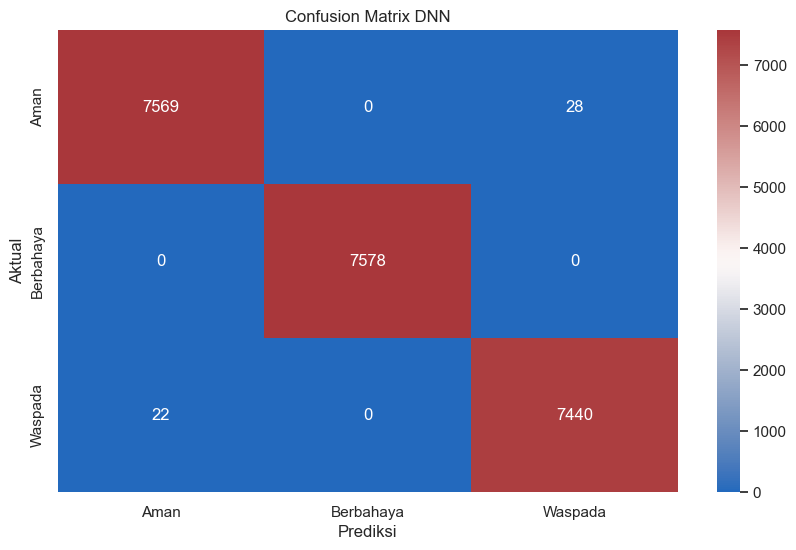


Evaluasi Model CNN:
Loss: 0.0028
Accuracy: 0.9992
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Laporan Klasifikasi CNN:
              precision    recall  f1-score   support

        Aman       1.00      1.00      1.00      7597
   Berbahaya       1.00      1.00      1.00      7578
     Waspada       1.00      1.00      1.00      7462

    accuracy                           1.00     22637
   macro avg       1.00      1.00      1.00     22637
weighted avg       1.00      1.00      1.00     22637



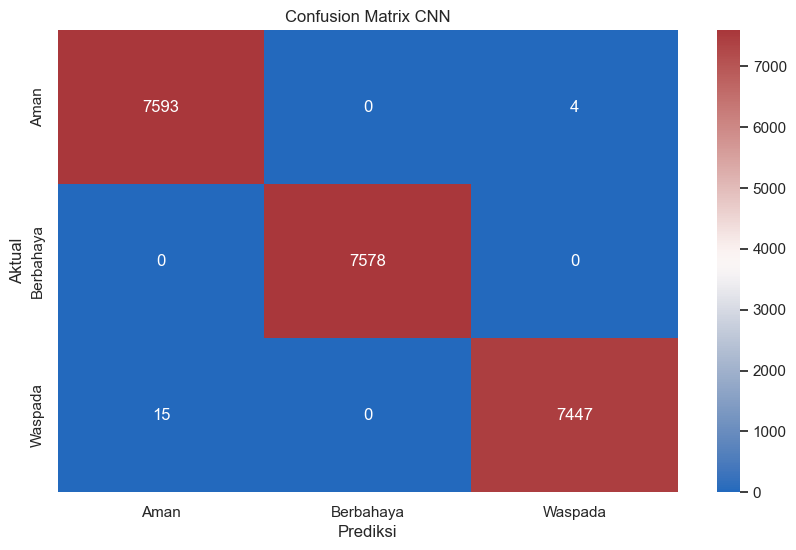

In [7]:
# Evaluasi DNN
print("\nEvaluasi Model DNN:")
loss_dnn, accuracy_dnn = model_dnn.evaluate(X_test, y_test_categorical, verbose=0)
print(f"Loss: {loss_dnn:.4f}")
print(f"Accuracy: {accuracy_dnn:.4f}")
y_pred_dnn = model_dnn.predict(X_test)
y_pred_dnn_labels = label_encoder.inverse_transform(np.argmax(y_pred_dnn, axis=1))
y_test_labels = label_encoder.inverse_transform(y_test)
print("\nLaporan Klasifikasi DNN:")
print(classification_report(y_test_labels, y_pred_dnn_labels, target_names=label_encoder.classes_))
cm_dnn = confusion_matrix(y_test_labels, y_pred_dnn_labels)
plt.figure()
sns.heatmap(cm_dnn, annot=True, fmt='d', cmap='vlag', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix DNN')
plt.show()

# Evaluasi CNN
print("\nEvaluasi Model CNN:")
loss_cnn, accuracy_cnn = model_cnn.evaluate(X_test_cnn, y_test_categorical, verbose=0)
print(f"Loss: {loss_cnn:.4f}")
print(f"Accuracy: {accuracy_cnn:.4f}")
y_pred_cnn = model_cnn.predict(X_test_cnn)
y_pred_cnn_labels = label_encoder.inverse_transform(np.argmax(y_pred_cnn, axis=1))
print("\nLaporan Klasifikasi CNN:")
print(classification_report(y_test_labels, y_pred_cnn_labels, target_names=label_encoder.classes_))
cm_cnn = confusion_matrix(y_test_labels, y_pred_cnn_labels)
plt.figure()
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='vlag', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix CNN')
plt.show()

## 💾 Simpan Model dan Preprocessor
Menyimpan model dan preprocessor untuk digunakan di Backend.

In [9]:
# Simpan model dan preprocessor
os.makedirs('../models', exist_ok=True)
model_dnn.save('../models/model_dnn.h5')
joblib.dump(preprocessor, '../models/preprocessor.pkl')
joblib.dump(label_encoder, '../models/label_encoder.pkl')

print("Model dan preprocessor telah disimpan di folder /models.")

Model dan preprocessor telah disimpan di folder /models.


## 🚀 Fungsi Inferensi pada Data Baru

Menunjukkan bagaimana menggunakan preprocessor, label encoder, dan model yang sudah disimpan untuk memprediksi risiko pada data baru, seperti yang akan dilakukan di Backend aplikasi.

In [12]:
import requests
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
from geopy.geocoders import Nominatim

def get_weather_data(latitude, longitude):
    """
    Mengambil data cuaca dari Open-Meteo API.
    """
    url = f'https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&daily=temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max&timezone=auto'
    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()
        data = response.json()
        daily = data['daily']
        return {
            'temperature_2m_max': daily['temperature_2m_max'][0],  # Ambil data hari pertama
            'temperature_2m_min': daily['temperature_2m_min'][0],  # Ambil data hari pertama
            'precipitation_sum': daily['precipitation_sum'][0],    # Ambil data hari pertama
            'windspeed_10m_max': daily['windspeed_10m_max'][0],   # Ambil data hari pertama
            'weathercode': 800  # Open-Meteo tidak menyediakan weathercode langsung, gunakan default
        }
    except (requests.RequestException, KeyError) as e:
        print(f"Gagal mengambil data cuaca: {e}. Menggunakan nilai default.")
        return {
            'temperature_2m_max': 29.5,
            'temperature_2m_min': 25.3,
            'precipitation_sum': 17.9,
            'windspeed_10m_max': 21.7,
            'weathercode': 800
        }

def get_location_data(latitude, longitude):
    """
    Mengambil nama lokasi dan kota.
    """
    try:
        geocoder = Nominatim(user_agent="mitigasi_kita")
        location = geocoder.reverse((latitude, longitude), language="id")
        if location:
            address = location.raw.get("address", {})
            city = address.get("city", address.get("town", address.get("village", "Ambon")))
            location_name = address.get("state", "Banda Sea")
            return location_name, city
        return "Banda Sea", "Ambon"
    except Exception as e:
        print(f"Gagal mengambil data lokasi: {e}")
        return "Banda Sea", "Ambon"

def determine_tsunami_potential(magnitude, depth):
    """
    Menentukan potensi tsunami.
    """
    if magnitude > 7 and depth < 30:
        return "Tinggi", "Bahaya"
    elif magnitude > 6:
        return "Sedang", "Waspada"
    else:
        return "Rendah", "Aman"

def prepare_features_from_location(latitude, longitude):
    """
    Menyiapkan fitur untuk inferensi.
    """
    if not (-90 <= latitude <= 90) or not (-180 <= longitude <= 180):
        raise ValueError("Nilai latitude atau longitude tidak valid.")
    
    weather_features = get_weather_data(latitude, longitude)
    location, city = get_location_data(latitude, longitude)
    
    earthquake_event_features = {
        'magnitude': 4.427889833,
        'mag_type': 'M',
        'depth': 28.0,
        'phasecount': 65,
        'azimuth_gap': 136,
        'potensi_tsunami': 'Rendah'
    }
    
    other_features = {
        'city': city,
        'location': location,
        'agency': 'BMKG',
        'potensi_gempa': 'Rendah'
    }
    
    all_input_features = {
        'latitude': float(latitude),
        'longitude': float(longitude),
        **weather_features,
        **earthquake_event_features,
        **other_features
    }
    
    feature_columns_ordered = preprocessor.feature_names_in_
    df_input = pd.DataFrame([all_input_features], columns=feature_columns_ordered)
    return df_input

# Muat model dan preprocessor
model = tf.keras.models.load_model('../models/model_dnn.h5')
preprocessor = joblib.load('../models/preprocessor.pkl')
label_encoder = joblib.load('../models/label_encoder.pkl')

# Contoh data
sample_data = {
    'latitude': -6.447021484,
    'longitude': 130.0571899
}

try:
    df_input = prepare_features_from_location(sample_data['latitude'], sample_data['longitude'])
    X_input = preprocessor.transform(df_input)
    pred_probs = model.predict(X_input)
    pred_label_idx = np.argmax(pred_probs, axis=1)[0]  # Indeks kelas dengan probabilitas tertinggi
    pred_label = label_encoder.inverse_transform([pred_label_idx])[0]  # Konversi indeks ke label
    confidence_score = float(pred_probs[0][pred_label_idx])  # Ambil probabilitas untuk kelas yang diprediksi
    
    magnitude = df_input['magnitude'].iloc[0]
    depth = df_input['depth'].iloc[0]
    potensi_tsunami, _ = determine_tsunami_potential(magnitude, depth)
    
    output = {
        'location': df_input['location'].iloc[0],
        'city': df_input['city'].iloc[0],
        'agency': 'BMKG',
        'mag_type': 'M',
        'magnitude': float(magnitude),
        'depth': float(depth),
        'azimuth_gap': float(df_input['azimuth_gap'].iloc[0]),
        'phasecount': int(df_input['phasecount'].iloc[0]),
        'potensi_tsunami': potensi_tsunami,
        'latitude': float(sample_data['latitude']),
        'longitude': float(sample_data['longitude']),
        'temperature_2m_min': float(df_input['temperature_2m_min'].iloc[0]),
        'temperature_2m_max': float(df_input['temperature_2m_max'].iloc[0]),
        'windspeed_10m_max': float(df_input['windspeed_10m_max'].iloc[0]), 
        'precipitation_sum': float(df_input['precipitation_sum'].iloc[0]),
        'status': pred_label,
        'confidence_score': confidence_score  # Tambahkan tingkat kepercayaan
    }
    
    print(f"Prediksi Risiko: {pred_label}")
    print(f"Tingkat Kepercayaan: {confidence_score:.2f}")  # Tampilkan dengan 2 desimal
    print(f"Output JSON: {output}")
except Exception as e:
    print(f"Error saat inferensi: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
Prediksi Risiko: Waspada
Tingkat Kepercayaan: 1.00
Output JSON: {'location': 'Maluku', 'city': 'Ambon', 'agency': 'BMKG', 'mag_type': 'M', 'magnitude': 4.427889833, 'depth': 28.0, 'azimuth_gap': 136.0, 'phasecount': 65, 'potensi_tsunami': 'Rendah', 'latitude': -6.447021484, 'longitude': 130.0571899, 'temperature_2m_min': 27.0, 'temperature_2m_max': 27.9, 'windspeed_10m_max': 24.7, 'precipitation_sum': 17.3, 'status': 'Waspada', 'confidence_score': 0.999882698059082}
